Import libraries.

In [27]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
 
# PyTorch visualization
import torchvision
import torchvision.transforms as transforms
 
# matplot
import matplotlib.pyplot as plt
%matplotlib inline

Getting datasets.

In [28]:
batch_size = 128
 
# getting dataset
train_dataset = torchvision.datasets.MNIST(
  root='./data',
  train=True,
  transform=transforms.ToTensor(),
  download=True,
)

# make DataLoader
train_loader = torch.utils.data.DataLoader(
  dataset=train_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=0
)

Encoder

In [29]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()
    self.fc = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_var = nn.Linear(hidden_dim, latent_dim)

  def forward(self, x):
    # calculate mean and st-dev of posterior distribution by NN
    h = torch.relu(self.fc(x))
    mu = self.fc_mu(h) # mean
    log_var = self.fc_var(h) # log of stdev^2

    # calculate the latent variable
    ## make standard-distributed random numbers
    eps = torch.randn_like(torch.exp(log_var))
    ## calculate the latent variable: mu + sigma*eps
    z = mu + torch.exp(log_var / 2) * eps
    return mu, log_var, z

Decoder.

In [30]:
class Decoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(latent_dim, hidden_dim)
    self.fc_output = nn.Linear(hidden_dim, input_dim)

  def forward(self, z):
    h = torch.relu(self.fc(z))
    output = torch.sigmoid(self.fc_output(h))
    return output

VAE

In [31]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
    self.decoder = Decoder(input_dim, hidden_dim, latent_dim)

  def forward(self, x):
    mu, log_var, z = self.encoder(x) # エンコード
    x_decoded = self.decoder(z) # デコード
    return x_decoded, mu, log_var, z

Loss function.

In [32]:
def loss_function(label, predict, mu, log_var):
  reconstruction_loss = F.binary_cross_entropy(predict, label, reduction='sum')
  kl_loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  vae_loss = reconstruction_loss + kl_loss
  return vae_loss, reconstruction_loss, kl_loss

Let's execute.

Epoch: 1, loss:  36980.0625, reconstruct loss:  33685.7461, KL loss:  3294.3164
Epoch: 1, loss:  30121.7500, reconstruct loss:  28190.6367, KL loss:  1931.1129
Epoch: 1, loss:  27559.9160, reconstruct loss:  26192.3984, KL loss:  1367.5182
Epoch: 1, loss:  27428.5195, reconstruct loss:  26189.2910, KL loss:  1239.2291
Epoch: 1, loss:  27122.9414, reconstruct loss:  25838.7578, KL loss:  1284.1846
Epoch: 1, loss:  26421.5000, reconstruct loss:  25058.8223, KL loss:  1362.6783
Epoch: 1, loss:  24307.9727, reconstruct loss:  22763.3516, KL loss:  1544.6208
Epoch: 1, loss:  24686.1055, reconstruct loss:  23238.4980, KL loss:  1447.6082
Epoch: 1, loss:  23705.9570, reconstruct loss:  22135.5547, KL loss:  1570.4025
Epoch: 2, loss:  22679.2461, reconstruct loss:  21110.2207, KL loss:  1569.0247
Epoch: 2, loss:  22540.8691, reconstruct loss:  21014.2402, KL loss:  1526.6296
Epoch: 2, loss:  22078.5234, reconstruct loss:  20414.9375, KL loss:  1663.5868
Epoch: 2, loss:  22065.5176, reconstruct

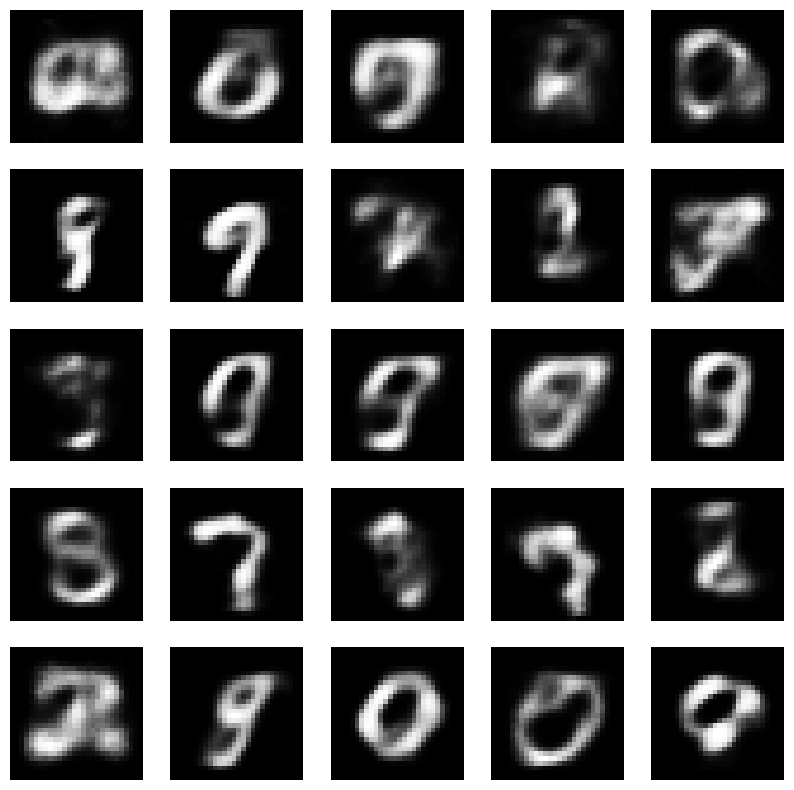

In [33]:
image_size = 28 * 28
h_dim = 32
z_dim = 16
num_epochs = 10
learning_rate = 1e-3

device = "cpu"

model = VAE(image_size, h_dim, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
model.train()
for epoch in range(num_epochs):
  train_loss = 0
  for i, (x, labels) in enumerate(train_loader):
    # prediction
    x = x.to(device).view(-1, image_size).to(torch.float32)
    x_recon, mu, log_var, z = model(x)

    # calculate loss function
    loss, recon_loss, kl_loss = loss_function(x, x_recon, mu, log_var)

    # update the parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # showing loss values
    if (i+1) % 50 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}, reconstruct loss: {recon_loss: 0.4f}, KL loss: {kl_loss: 0.4f}')
    losses.append(loss)

model.eval()

with torch.no_grad():
  z = torch.randn(25, z_dim).to(device)
  out = model.decoder(z)
out = out.view(-1, 28, 28)
out = out.cpu().detach().numpy()

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
plt.gray()
for i in range(25):
  idx = divmod(i, 5)
  ax[idx].imshow(out[i])
  ax[idx].axis('off');

# fig.show()  # not necesarry in Jupyter